In [20]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math

def show(img, code=cv2.COLOR_BGR2RGB):
    cv_rgb = cv2.cvtColor(img, code)
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.imshow(cv_rgb)
    fig.show()

In [58]:
def createLineIterator(P1, P2, img):
    """
    Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])     
    """
    #define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    #difference and absolute difference between points
    #used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    #predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa,dXa),3),dtype=np.float32)
    itbuffer.fill(np.nan)

    #Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X: #vertical line segment
        itbuffer[:,0] = P1X
        if negY:
            itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
        else:
            itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
    elif P1Y == P2Y: #horizontal line segment
        itbuffer[:,1] = P1Y
        if negX:
            itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
        else:
            itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
    else: #diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
            slope = dX.astype(np.float32)/dY.astype(np.float32)
            if negY:
                itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
            else:
                itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
            itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(np.int) + P1X
        else:
            slope = dY.astype(np.float32)/dX.astype(np.float32)
            if negX:
                itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
            else:
                itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
            itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(np.int) + P1Y

    #Remove points outside of image
    colX = itbuffer[:,0]
    colY = itbuffer[:,1]
    itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

    #Get intensities from img ndarray
    itbuffer[:,2] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]

    return itbuffer

In [166]:
def isTimingPattern(line):
    # 除去开头结尾的白色像素点
#     while line[0] != 0:
#         line = line[1:]
#     while line[-1] != 0:
#         line = line[:-1]
        
    # 计数连续的黑白像素点
    c = []
    count = 1
    l = line[0]
    for p in line[1:]:
        if p == l:
            count = count + 1
        else:
            c.append(count)
            count = 1
        l = p
    c.append(count)
    # 如果黑白间隔太少，直接排除
    if len(c) < 5:
        return False
    # 计算方差，根据离散程度判断是否是 Timing Pattern
    threshold = 5
    return np.var(c) < threshold

In [176]:
def cv_distance(P, Q):
    return int(math.sqrt(pow((P[0] - Q[0]), 2) + pow((P[1] - Q[1]),2)))
def check(a, b):
    # 存储 ab 数组里最短的两点的组合
    s1_ab = ()
    s2_ab = ()
    # 存储 ab 数组里最短的两点的距离，用于比较
    s1 = np.iinfo('i').max
    s2 = s1
    for ai in a:
        for bi in b:
            d = cv_distance(ai, bi)
            if d < s2:
                if d < s1:
                    s1_ab, s2_ab = (ai, bi), s1_ab
                    s1, s2 = d, s1
                else:
                    s2_ab = (ai, bi)
                    s2 = d              
    a1, a2 = s1_ab[0], s2_ab[0]
    b1, b2 = s1_ab[1], s2_ab[1]
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    th, bi_img = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY)
    # 将最短的两个线画出来
    cv2.line(draw_img, a1, b1, (0,0,255), 3)
    cv2.line(draw_img, a2, b2, (0,0,255), 3)
    lit1 = createLineIterator(a1,b1,bi_img)
    lit2 = createLineIterator(a2,b2,bi_img)
        
    return True
    
#     if isTimingPattern(lit1[:,2]):
#         return True
#     elif isTimingPattern(lit2[:,2]):
#         return True
#     else:
#         return False

/home/swrd/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


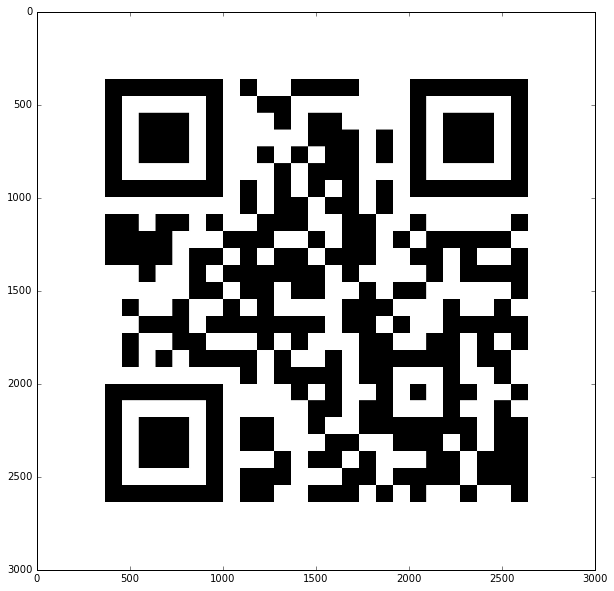

In [95]:
img = cv2.imread('qr-codes-business-cards.jpg')
show(img)

In [96]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gb = cv2.GaussianBlur(img_gray, (5, 5), 0)
edges = cv2.Canny(img_gray, 100 , 200)

/home/swrd/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


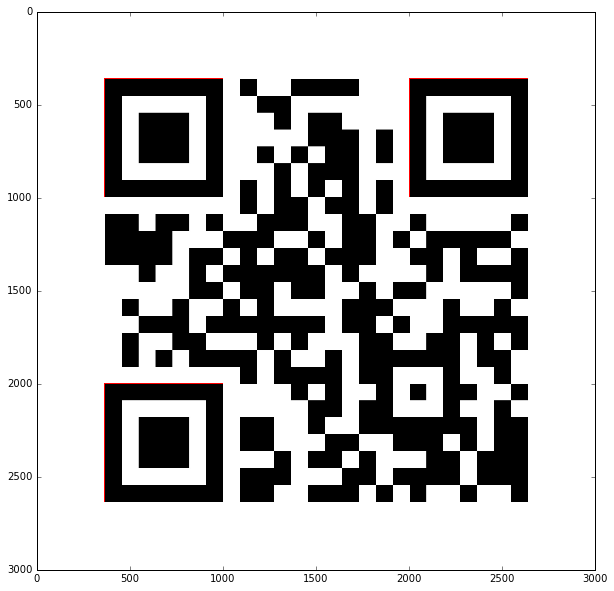

In [97]:
img_fc, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
hierarchy = hierarchy[0]
found = []
for i in range(len(contours)):
    k = i
    c = 0
    while hierarchy[k][2] != -1:
        k = hierarchy[k][2]
        c = c + 1
    if c >= 5:
        found.append(i)

draw_img = img.copy()
for i in found:
    rect = cv2.minAreaRect(contours[i])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(draw_img,[box], 0, (0,0,255), 2)
show(draw_img)
        
# for i in found:
#     img_dc = img.copy()
#     cv2.drawContours(img_dc, contours, i, (0, 255, 0), 3)
#     show(img_dc)

In [177]:
boxes = []
for i in found:
    rect = cv2.minAreaRect(contours[i])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
#     box = map(tuple, box)
    box = [tuple(x) for x in box]
    boxes.append(box)

/home/swrd/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


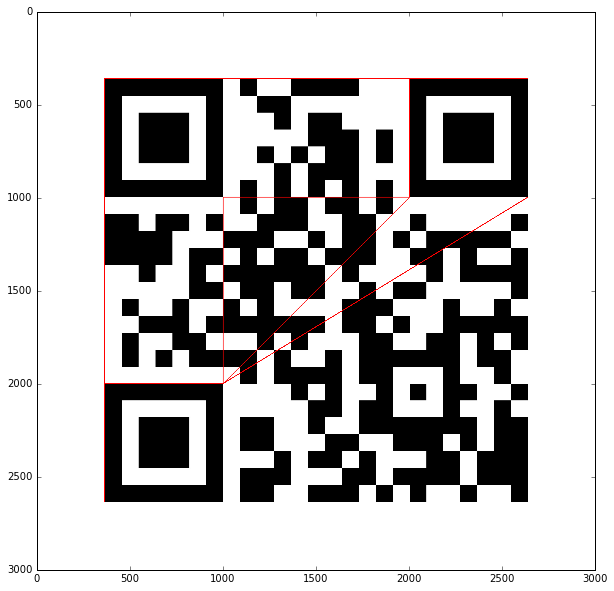

In [178]:
for i in range(len(boxes)):
    for j in range(i+1, len(boxes)):
        check(boxes[i], boxes[j])
        
show(draw_img)

In [179]:
valid = set()
for i in range(len(boxes)):
    for j in range(i+1, len(boxes)):
        if check(boxes[i], boxes[j]):
            valid.add(i)
            valid.add(j)
# print (valid)

/home/swrd/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


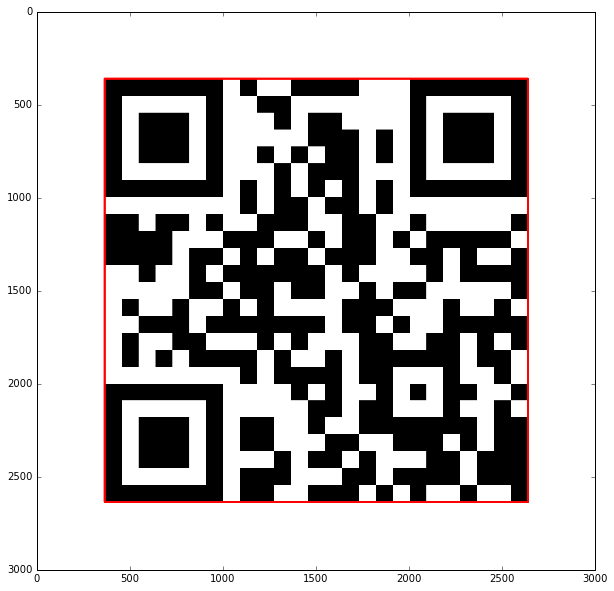

In [180]:
contour_all = []

while len(valid) > 0:
    c = contours[found[valid.pop()]]
    for sublist in c:
        for p in sublist:
            contour_all.append(p)
            
rect = cv2.minAreaRect(np.array(contour_all))
box = cv2.boxPoints(rect)
box = np.array(box)
draw_img = img.copy()
cv2.polylines(draw_img, np.int32([box]), True, (0, 0, 255), 10)
show(draw_img)            